In [53]:

#now we can read the file
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


file_name = "FRB20190212A_waterfall.h5"
data = h5py.File(file_name, "r")

data = data["frb"]
eventname = data.attrs["tns_name"].decode()
wfall = data["wfall"][:]
model_wfall = data["model_wfall"][:]
plot_time = data["plot_time"][:]
plot_freq = data["plot_freq"][:]
ts = data["ts"][:]
model_ts = data["model_ts"][:]
spec = data["spec"][:]
model_spec = data["model_spec"][:]
extent = data["extent"][:]
dm = data.attrs["dm"][()]
scatterfit = data.attrs["scatterfit"][()]
cal_obs_date = data.attrs["calibration_observation_date"].decode()
cal_source_name = data.attrs["calibration_source_name"].decode()
cal_wfall =  data["calibrated_wfall"][:]

dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
# this value is the same for both caliberated and uncalibrated data

q1 = np.nanquantile(spec, 0.25)
q3 = np.nanquantile(spec, 0.75)
iqr = q3 - q1

# additional masking of channels with RFI
rfi_masking_var_factor = 3

channel_variance = np.nanvar(wfall, axis=1)
mean_channel_variance = np.nanmean(channel_variance)

with np.errstate(invalid="ignore"):
    rfi_mask = (channel_variance > \
                rfi_masking_var_factor * mean_channel_variance) \
                | (spec[::-1] < q1 - 1.5 * iqr) | (spec[::-1] > q3 + 1.5 * iqr)
wfall[rfi_mask,...] = np.nan
model_wfall[rfi_mask,...] = np.nan
spec[rfi_mask[::-1]] = np.nan

# remake time-series after RFI masking
ts = np.nansum(wfall, axis=0)
model_ts = np.nansum(model_wfall, axis=0)

def boxcar_kernel(width):
    width = int(round(width, 0))
    return np.ones(width, dtype="float32") / np.sqrt(width)


def find_burst(ts, min_width=1, max_width=128):
    min_width = int(min_width)
    max_width = int(max_width)
    # do not search widths bigger than timeseries
    widths = list(range(min_width, min(max_width + 1, len(ts)-2)))
    # envelope finding
    snrs = np.empty_like(widths, dtype=float)
    peaks = np.empty_like(widths, dtype=int)
    for i in range(len(widths)):
        convolved = scipy.signal.convolve(ts, boxcar_kernel(widths[i]), mode="same")
        peaks[i] = np.nanargmax(convolved)
        snrs[i] = convolved[peaks[i]]
    best_idx = np.nanargmax(snrs)
    return peaks[best_idx], widths[best_idx], snrs[best_idx]

peak, width, snr = find_burst(ts)
print(f"Peak: {peak} at time sample, Width = {width*dt} ms, SNR = {snr}")


def bin_freq_channels(data, fbin_factor=4):
    num_chan = data.shape[0]
    if num_chan % fbin_factor != 0:
        raise ValueError("frequency binning factor `fbin_factor` should be even")
    data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)
    return data

# bin frequency channels such that we have 16,384/16 = 1024 frequency channels 
wfall = bin_freq_channels(wfall, 16)


Peak: 13 at time sample, Width = 5.898240488022566 ms, SNR = 157.56955596716045


C:\Users\nichb\AppData\Local\Temp\ipykernel_15916\935545132.py:39: RuntimeWarning: Degrees of freedom <= 0 for slice.
  channel_variance = np.nanvar(wfall, axis=1)
C:\Users\nichb\AppData\Local\Temp\ipykernel_15916\935545132.py:82: RuntimeWarning: Mean of empty slice
  data = np.nanmean(data.reshape((num_chan // fbin_factor, fbin_factor) + data.shape[1:]), axis=1)


Text(0.5, 0, 'Time [ms]')

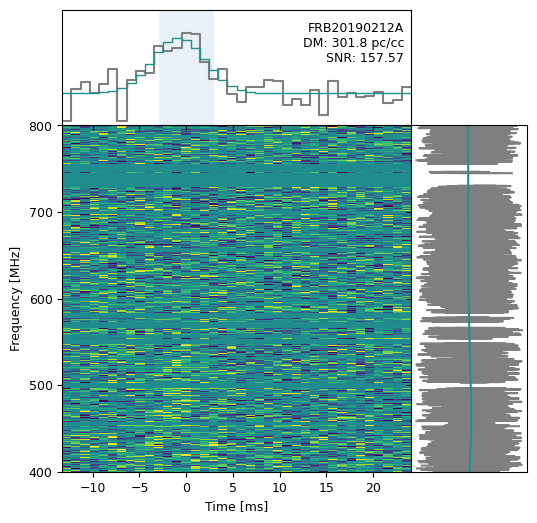

In [54]:


fig = plt.figure(figsize=(6,6))
## Set up the image grid
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[3, 1],
                        height_ratios=[1, 3], hspace=0.0, wspace=0.0)
data_im = plt.subplot(gs[2])
data_ts = plt.subplot(gs[0], sharex=data_im)
data_spec = plt.subplot(gs[3], sharey=data_im)


### time stamps relative to the peak
peak_idx = np.argmax(ts)
extent[0] = extent[0] - plot_time[peak_idx]
extent[1] = extent[1] - plot_time[peak_idx]
plot_time -= plot_time[peak_idx]

# prepare time-series for histogramming
plot_time -= dt / 2.
plot_time = np.append(plot_time, plot_time[-1] + dt)

cmap = plt.cm.viridis

### plot dynamic spectrum
wfall[np.isnan(wfall)] = np.nanmedian(wfall)   # replace nans in the data with the data median
# use standard deviation of residuals to set color scale
vmin = np.nanpercentile(wfall, 1)
vmax = np.nanpercentile(wfall, 99)

data_im.imshow(wfall, aspect="auto", interpolation="none",
                extent=extent, vmin=vmin, vmax=vmax, cmap=cmap)

### plot time-series
data_ts.plot(plot_time, np.append(ts, ts[-1]), color="tab:gray",
                drawstyle="steps-post")

### plot spectrum
data_spec.plot(spec, plot_freq, color="tab:gray")

### plot model time-series and spectrum
if scatterfit:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.25))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.25), drawstyle="steps-post", lw=2)
else:
    data_spec.plot(model_spec, plot_freq, color=cmap(0.5))
    data_ts.plot(plot_time, np.append(model_ts, model_ts[-1]),
                    color=cmap(0.5), drawstyle="steps-post", lw=1)


## BEautify plot
# remove some labels and ticks for neatness
plt.setp(data_ts.get_xticklabels(), visible=False)
data_ts.set_yticklabels([], visible=True)
data_ts.set_yticks([])
data_ts.set_xlim(extent[0], extent[1])
plt.setp(data_spec.get_yticklabels(), visible=False)
data_spec.set_xticklabels([], visible=True)
data_spec.set_xticks([])
data_spec.set_ylim(extent[2], extent[3])
plt.setp(data_im.get_xticklabels(), fontsize=9)
plt.setp(data_im.get_yticklabels(), fontsize=9)


#### highlighting the width of the pulse
data_ts.axvspan(max(plot_time.min(),
                        plot_time[peak] + 0.5 * dt \
                        - (0.5 * width) * dt),
                    min(plot_time.max(),
                        plot_time[peak] + 0.5 * dt \
                        + (0.5 * width) * dt),
                    facecolor="tab:blue", edgecolor=None, alpha=0.1)


##### add event ID and DM labels
xlim = data_ts.get_xlim()
ylim = data_ts.get_ylim()

# add 20% extra white space at the top
span = np.abs(ylim[1]) + np.abs(ylim[0])
data_ts.set_ylim(ylim[0], ylim[1] + 0.2 * span)
ylim = data_ts.get_ylim()

ypos = (ylim[1] - ylim[0]) * 0.9 + ylim[0]
xpos = (xlim[1] - xlim[0]) * 0.98 + extent[0]
data_ts.text(xpos, ypos, "{}\nDM: {:.1f} pc/cc\nSNR: {:.2f}".format(eventname, dm,snr), ha="right",
                va="top", fontsize=9)

data_im.locator_params(axis="x", min_n_ticks=3)
data_im.set_yticks([400, 500, 600, 700, 800])
data_im.set_ylabel("Frequency [MHz]", fontsize=9)
data_im.set_xlabel("Time [ms]", fontsize=9)

In [51]:
import numpy as np
import matplotlib.pyplot as plt

file_name = "FRB20190212A_waterfall.h5"
data = h5py.File(file_name, "r")

data = data["frb"]
eventname = data.attrs["tns_name"].decode()
wfall = data["wfall"][:]
model_wfall = data["model_wfall"][:]
plot_time = data["plot_time"][:]
plot_freq = data["plot_freq"][:]
ts = data["ts"][:]
model_ts = data["model_ts"][:]
spec = data["spec"][:]
model_spec = data["model_spec"][:]
extent = data["extent"][:]
dm = data.attrs["dm"][()]
scatterfit = data.attrs["scatterfit"][()]
cal_obs_date = data.attrs["calibration_observation_date"].decode()
cal_source_name = data.attrs["calibration_source_name"].decode()
cal_wfall =  data["calibrated_wfall"][:]

print(wfall.shape)
print(model_wfall.shape)
print(plot_time.shape)
print(plot_freq.shape)
print(ts.shape)
print(model_ts.shape)
print(spec.shape)
print(model_spec.shape)
print(extent.shape)
print(dm)
print(scatterfit)
print(cal_obs_date)
print(cal_source_name)
print(cal_wfall.shape)



(16384, 38)
(16384, 38)
(38,)
(16384,)
(38,)
(38,)
(16384,)
(16384,)
(4,)
301.78365617495615
False
2019-02-12
3C_61.1
(16384, 384)


dict_keys(['intensity', 'fbottom', 'df', 'tstart', 'dt', 'dm', 'nchan', 'nsamp', 'ftop', 'bandwidth', 'frequencies', 'center_frequencies', 'tend', 'times', 'center_times', 'weights', 'beam_no'])
(16384, 256)
(16384,)
(256,)
(256, 256)


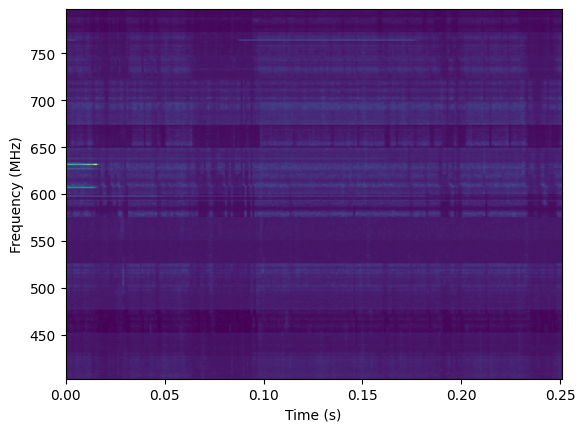

In [55]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("244065354_rfi.npy",allow_pickle=True).tolist()

#Intensity data is accessed by the key "intensity"
#the intensity data is 16384 frequency channels x 256 time samples
print(data.keys())
intensity = data["intensity"]
print(intensity.shape)
#access the frequency steps between 400-800 MHz
center_frequencies = data["center_frequencies"]
center_times = data["dt"]*np.arange(intensity.shape[1])
print(center_frequencies.shape)
print(center_times.shape)
#Average down to 256 frequency channels
intensity_downsampled = np.mean(intensity.reshape(16384//256,256,-1),axis=0)
print(intensity_downsampled.shape)
#grab the new center frequencies
center_frequencies_downsampled = center_frequencies.reshape(16384//256,-1).mean(axis=1)
#plot the RFI
plt.imshow(intensity_downsampled,aspect='auto',extent=[center_times[0],center_times[-1],center_frequencies_downsampled[0],center_frequencies_downsampled[-1]])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.show()

(16384, 38)
(16384,)
(38,)
(256, 38)


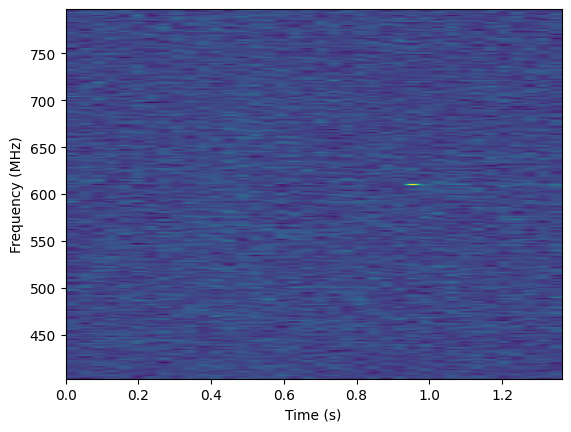

[[-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]
 [-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]
 [-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]
 ...
 [-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]
 [-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]
 [-0.0064314 -0.0064314 -0.0064314 ... -0.0064314 -0.0064314 -0.0064314]]


In [52]:
wfall[np.isnan(wfall)] = np.nanmedian(wfall)
model_wfall[np.isnan(model_wfall)] = np.nanmedian(model_wfall)


intensity = wfall
center_times = data["plot_time"][:]*np.arange(intensity.shape[1])/1000
center_frequencies = data["plot_freq"][:]



#intensity = data["intensity"]
print(intensity.shape)
#access the frequency steps between 400-800 MHz
#center_frequencies = data["center_frequencies"]
#center_times = data["dt"]*np.arange(intensity.shape[1])
print(center_frequencies.shape)
print(center_times.shape)
#Average down to 256 frequency channels
intensity_downsampled = np.mean(intensity.reshape(16384//256,256,-1),axis=0)
print(intensity_downsampled.shape)
#grab the new center frequencies
center_frequencies_downsampled = center_frequencies.reshape(16384//256,-1).mean(axis=1)
#plot the RFI
plt.imshow(intensity_downsampled,aspect='auto',extent=[center_times[0],center_times[-1],center_frequencies_downsampled[0],center_frequencies_downsampled[-1]])
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.show()

print(intensity)